# LOG6308 : Tp1 - Recommendation by collaboratif filtering 

- Clément Bernard (2096223)
- Ghaith Dekhili ()

## Importations 

In [74]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import time

## Data 

In [2]:
# The path where is the fold data
PATH_DATA = 'data'

In [3]:
# The items 
items = pd.read_csv(os.path.join(PATH_DATA, 'items.csv'), sep='|')
# User data 
u = pd.read_csv(os.path.join(PATH_DATA, 'u.csv'), sep='|')
# Votes of the user 
votes = pd.read_csv(os.path.join(PATH_DATA, 'votes.csv'), sep='|')

## Creation of sparse matrix : User-item matrix

In [7]:
# The number of users 
N_USERS = u.shape[0]
# The number of items 
N_ITEMS = items.shape[0]

In [8]:
def create_sparse_matrix(votes) : 
    ''' Create a User-Items sparse matrix '''
    # Create NaN for each items and users 
    data = {i : [np.nan for j in range(N_USERS + 1)] for i in range(N_ITEMS+1)}
    def to_convert(x, data) :
        data[x['item.id']][x['user.id']] = x['rating']
        return None 
    votes.apply(to_convert , axis = 1 , args = [data])
    return pd.DataFrame(data)

In [9]:
user_item = create_sparse_matrix(votes)

In [10]:
user_item

,0,1,2,3,4,5,6,7,8,9,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Question 1 

- Tout d'abord, nous creons les indexes qui vont permettre de diviser nos données pour la cross-validation

In [11]:
def kfold(n_data, k = 10 , SEED = 77, shuffle = False ) : 
    ''' Split the data into K-Folds 
        Input : The length of the data to split 
        Output : The indexes of the different folds 
    '''
    # Fix the SEED to have consistent results 
    np.random.seed(SEED)
    # Create the indexes 
    indexes = np.arange(n_data)
    # Shuffle the matrix 
    if shuffle : 
        np.random.shuffle(indexes)
    # The size of the subindexes
    sub_size = n_data // k 
    # Size of the last fold used for the test 
    last_size = sub_size + n_data%k
    # Where we store all the indexes 
    all_indexes = {'train' : [], 'test' : []}
    # Index of the test 
    test_i = 0 
    for i in range(k) :
        train = []
        # Check if we are the last set 
        if test_i == k-1 : 
            all_indexes['test'].append(indexes[-last_size:])
            all_indexes['train'].append(indexes[:-last_size ])
        else : 
            all_indexes['test'].append(indexes[ test_i * sub_size : (test_i+1) * sub_size ])
            # Get the indexes outside the test indexes
            train = [] 
            train.extend(indexes[:test_i * sub_size])
            train.extend(indexes[(test_i+1) * sub_size : ])
            all_indexes['train'].append(train)
        
        
        test_i +=1 
        
    return all_indexes


- Maintenant, nous implémentons les fonctions pour calculer les valeurs moyennes des utilisateurs et items 

In [12]:
def average_user(user_item) : 
    ''' Compute the average score for the users '''
    # Compute the mean for the users 
    return user_item.apply( lambda x : np.mean(x) , axis = 1 ).iloc[1:]
    
def average_item(user_item) : 
    ''' Compute the average score for the items '''
    # Compute the mean for the items 
    return user_item.apply( lambda x : np.mean(x) , axis = 0 ).iloc[1:]

In [13]:
# The mean by users 
user_item_mean_u = average_user(user_item)
# The mean by items
user_item_mean_i = average_item(user_item)

- Valeur moyenne par utilisateur 

In [14]:
user_item_mean_u

1      3.610294
2      3.709677
3      2.796296
4      4.333333
5      2.874286
         ...   
939    4.265306
940    3.457944
941    4.045455
942    4.265823
943    3.410714
Length: 943, dtype: float64

- Valeur moyenne par item

In [15]:
user_item_mean_i

1       3.878319
2       3.206107
3       3.033333
4       3.550239
5       3.302326
          ...   
1678    1.000000
1679    3.000000
1680    2.000000
1681    3.000000
1682    3.000000
Length: 1682, dtype: float64

- Utilisation de la cross-validation pour calculer l'erreur 

In [12]:
user_item

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
def cross_validation(N ,k , votes = votes , user_item = user_item) : 
    ''' Compute the quadratic error with K-cross-validation
        Inputs : 
            - N : The size of the data to split (either size of items or users)
    '''
    # Dictionnary that will store the errors 
    errors = {}
    # Loop over the K-Folds 
    for i, (i_train, i_test) in enumerate(zip(*kfold(N,k, shuffle = True ).values())) : 
        # Copy the original user-item matrix 
        u_item = user_item.copy()
        # Get the indexes of the test 
        indexes_test = votes.iloc[i_test,:2]
        
        def to_convert(x, user_item) :
            # Make the test rating to NaN
            user_item[x['item.id']][x['user.id']] = np.nan
        # Convert the test rating to NaN
        indexes_test.apply(to_convert , axis = 1 , args = [u_item])
        # Get the mean within the training indexes
        mean_item = average_item(u_item)
        mean_user = average_user(u_item)
        # Set the error to 0
        errors[i] = 0 
        
        def compute_dist(x, mean_item, mean_user, user_item, errors, i) :
            '''Compute the RMSE''' 
            # Get the item id 
            item = x['item.id']
            # Get the user id 
            user = x['user.id']
            # Make the prediction : the mean between user and item score 
            prediction = (mean_item[item] + mean_user[user])/2
            # Get the true label 
            true_value = user_item.iloc[user,item]
            # Compute the error 
            error = np.sqrt( ( prediction - true_value)**2)
            # If NaN : pass
            if np.isnan(error) : 
                return None
            # Increment the error 
            errors[i]+=error
            return None 
        # Apply the computation of RMSE 
        indexes_test.apply(compute_dist, axis = 1 , args = [mean_item, mean_user, user_item, errors,i])
        # Normalise by the size of the testing set 
        errors[i]/=indexes_test.shape[0]
            
    return errors
    

In [ ]:
error_user = cross_validation( N = votes.shape[0] ,k = 10  )

In [ ]:
error_user

In [ ]:
plt.bar(list(error_user.keys()) , list(error_user.values()))

- Print the results 

In [ ]:
print('Mean square error for all the K-folds : {}'.format(error_user))
print('Mean square error for all the folds : {}'.format(np.mean(list(error_user.values()))))

## Question 2 

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import time

In [ ]:
# The path where is the fold data
PATH_DATA = 'data'

In [ ]:
# The items 
items = pd.read_csv(os.path.join(PATH_DATA, 'items.csv'), sep='|')
# User data 
u = pd.read_csv(os.path.join(PATH_DATA, 'u.csv'), sep='|')
# Votes of the user 
votes = pd.read_csv(os.path.join(PATH_DATA, 'votes.csv'), sep='|')

In [ ]:
# The number of users 
N_USERS = u.shape[0]
# The number of items 
N_ITEMS = items.shape[0]

In [ ]:
def create_sparse_matrix(votes) : 
    ''' Create a User-Items sparse matrix '''
    # Create NaN for each items and users 
    data = {i : [np.nan for j in range(N_USERS + 1)] for i in range(N_ITEMS+1)}
    def to_convert(x, data) :
        data[x['item.id']][x['user.id']] = x['rating']
        return None 
    votes.apply(to_convert , axis = 1 , args = [data])
    return pd.DataFrame(data)

In [ ]:
user_item = create_sparse_matrix(votes)

In [11]:
#user_item matrix index should start from 1 
user_item = user_item.iloc[1:,1:]
item_item = user_item.T.copy()

### 2.a Distribution (histogramme) des similarités (poids w )

In [16]:
def get_similarity_matrix(item_item) : 
    ''' Return a dataframe of size : N_ITEM x N_ITEM with the similarity for each user 
            within the other items '''
     
    df_sim = pd.DataFrame(np.zeros((N_ITEMS, N_ITEMS)), index = range(1,N_ITEMS+1), columns = range(1,N_ITEMS+1))
    for a in range(N_ITEMS) :
        df_sim.iloc[a] = cosine_similarity(item_item.iloc[a].fillna(0).values.reshape(1, -1), item_item.fillna(0))
    return df_sim

In [18]:
initial_time = time.time()
def_sim = get_similarity_matrix(item_item)
print(time.time()-initial_time)

61.091843366622925


In [19]:
def_sim.head()

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
2,0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
3,0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
4,0.454938,0.502571,0.324866,1.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
5,0.286714,0.318836,0.212957,0.334239,1.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211


In [159]:
def return_similarities_distribution(def_sim):
    """
    return similarities distribution
    """
    similarities_distribution = def_sim.values.flatten()
    plt.hist(similarities_distribution, color = 'blue', edgecolor = 'black', bins = int(180/5), log=True)

    # Add labels
    plt.title('Similarities distribution')
    plt.xlabel('x',fontsize=15)
    plt.ylabel('y',fontsize=15)
    return similarities_distribution

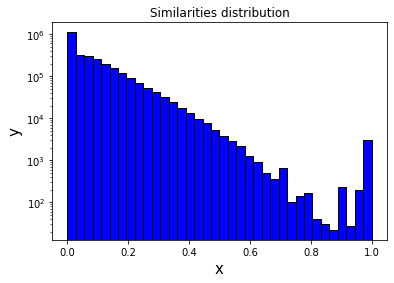

In [160]:
similarities_distribution = return_similarities_distribution(def_sim)

### La proportion de poids nuls

In [161]:
def print_zeros_weights_proportion(df):
    """
    prints proportion of zeros among all similarities values
    """
    listOfSimilarities = df.values.flatten()
    numZeros = 0
    for z in listOfSimilarities:
        if z == 0:
            numZeros +=1
    print("proportion of zero weights = ", numZeros/len(listOfSimilarities))

In [162]:
print_zeros_weights_proportion(def_sim)

proportion of zero weights =  0.3043450905651361


### 2.b 

In [24]:
def buil_neighbors_indexes(item_item):
    """
    Returns a df with items and their neighbors with similarities and a df with neighbors' indexes 
    """
    #A df for items and their neighbors with similarities
    df_10_neighbors = pd.DataFrame(np.zeros((N_ITEMS, 10)), index = range(1,N_ITEMS+1))  
    #A df for items with their neighbors' indexes 
    df_10_index = pd.DataFrame(np.zeros((N_ITEMS, 10)), index = range(1,N_ITEMS+1))                            
    #count = 0
    for i in range(len(item_item)):
        mySeries = def_sim.iloc[i].copy()    
        for n in range(10):
            max_val = mySeries.values.max()
            max_idx = pd.Index(mySeries).get_loc(max_val)
            
            #we don't take the actual item as neighbor of itself
            if type(max_idx) is int and max_idx == i:
                mySeries = mySeries.drop(mySeries.index[max_idx])
                max_val = mySeries.values.max()
                max_idx = pd.Index(mySeries).get_loc(max_val)
            
            #There are some max with a list of boolean as index, so we don't take them
            while type(max_idx) is not int:
                #count +=1
                mySeries = mySeries.drop(mySeries.index[max_idx])
                max_val = mySeries.values.max()
                max_idx = pd.Index(mySeries).get_loc(max_val)            
            
            df_10_neighbors.iloc[i,n] =  max_val
            #in the next line we add 1 as our items index start with 1  
            df_10_index.iloc[i,n] = int(max_idx+1)
            mySeries = mySeries.drop(mySeries.index[max_idx])
            #print("count:",count)
    return df_10_neighbors, df_10_index

In [25]:
df_10_neighbors_sim,df_10_index = buil_neighbors_indexes(item_item)

In [26]:
df_10_neighbors_sim.head()

,0,1,2,3,4,5,6,7,8,9
1,0.734572,0.699925,0.689786,0.664555,0.641322,0.638158,0.636727,0.630601,0.624075,0.622382
2,0.659619,0.623544,0.617274,0.616143,0.604969,0.601960,0.597083,0.595684,0.590124,0.584100
3,0.452023,0.444355,0.423249,0.404930,0.404787,0.404239,0.404080,0.401676,0.397274,0.396868
4,0.650507,0.628946,0.628720,0.620055,0.617312,0.604652,0.602747,0.601488,0.601319,0.599989
5,0.547787,0.472725,0.472399,0.450780,0.445242,0.440996,0.435349,0.430292,0.425298,0.424652


In [27]:
df_10_neighbors_sim.shape

(1682, 10)

In [29]:
df_10_index.head()

,0,1,2,3,4,5,6,7,8,9
1,49.0,179.0,119.0,115.0,400.0,147.0,216.0,98.0,229.0,168.0
2,232.0,160.0,382.0,399.0,61.0,570.0,223.0,227.0,542.0,94.0
3,409.0,761.0,41.0,32.0,247.0,16.0,1040.0,818.0,469.0,231.0
4,55.0,202.0,172.0,199.0,94.0,191.0,169.0,208.0,77.0,375.0
5,217.0,217.0,53.0,230.0,52.0,95.0,665.0,196.0,657.0,551.0


In [28]:
df_10_index.shape

(1682, 10)

##### Proportion de votes manquants

In [158]:
def return_missed_votes_distribution(df_10_index, user_item_centred, df_10_neighbors_sim):
    '''
    return missed votes per item distribution
    '''
    missed_votes_distribution = []
    for item in range(1,N_ITEMS+1):
        #To return a (943,10) df with votes from user_item matrix from the original user_item df
        df_10_votes = build_users_items_neigh_mtx(df_10_index.loc[item],user_item_centred)
        missed_votes_distribution.append(df_10_votes.isna().sum().sum())
 
    plt.hist(missed_votes_distribution, color = 'blue', edgecolor = 'black', bins = int(180/5), log=True)     
    # Add labels
    plt.title('Distribution de votes manquants par item')
    plt.xlabel('x',fontsize=15)
    plt.ylabel('y',fontsize=15)
    
    return missed_votes_distribution  

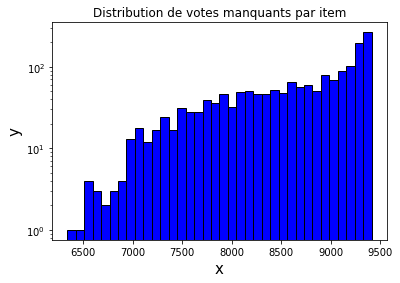

In [150]:
missed_votes_distribution = return_missed_votes_distribution(df_10_index, user_item_centred, df_10_neighbors_sim)

##### Distribution du nombre de voisins avec votes communs par item

In [156]:
def return_common_votes_distribution(missed_votes_distribution):
    '''
    return neighbors with common votes per item distribution 
    ''' 
    common_votes_distribution = [(N_USERS*10 - n_miss_votes) for n_miss_votes in missed_votes_distribution]
    
    plt.hist(common_votes_distribution, color = 'blue', edgecolor = 'black', bins = int(180/5), log=True)
    # Add labels
    plt.title('Distribution du nombre de voisins avec votes communs par item')
    plt.xlabel('x',fontsize=15)
    plt.ylabel('y',fontsize=15)
    
    return common_votes_distribution

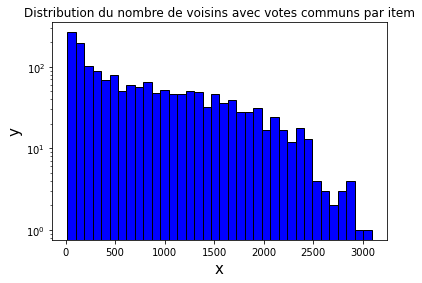

In [157]:
common_votes_distribution = return_common_votes_distribution(missed_votes_distribution)

#### 2.c effectuer le calcul pour le premier item 

In [136]:
def centre_df(user_item):
    """
    Create a df with centered votes of user_item
    """
    user_item_centred = user_item.add(-user_item.mean())
    
    return user_item_centred

In [137]:
user_item_centred = centre_df(user_item)

In [30]:
def build_users_items_neigh_mtx(df_10_index_i,user_item):
    """
    builds an item votes matrix of users with 10 neighbors of this item (V in the video)
    """
    df_10_votes = pd.DataFrame(np.zeros((N_USERS, 10)), index = range(1,N_USERS+1))
                          
    #loop over 10 neighbors indexes of the actual item "i"                            
    for index, value in df_10_index_i.items():
        #fill df with the votes associated to these 10 neighbors
        df_10_votes[index] = user_item[int(value)] 
    
    return df_10_votes

In [125]:
def estimate_votes(item, df_10_neighbors_sim, df_10_votes):
    """
    returns 10 neighbors votes given an item
    """
    #get item's 10 neighbors weights wich is W, note that it is the same for all users for a selected item
    item_weights = pd.DataFrame(df_10_neighbors_sim.loc[item])  
    C_df = pd.DataFrame(df_10_votes.copy())
    C_df[~df_10_votes.isnull()==True] = 1
    C_df[~df_10_votes.isnull()==False] = 0
    masked_weights = np.dot(C_df,item_weights)
    df_masked_weights = pd.DataFrame(masked_weights, index = range(1,N_USERS+1))
    K = (1/df_masked_weights.fillna(0)).replace(np.inf,0)
    
    return K*(np.dot(df_10_votes.fillna(0),item_weights))

In [131]:
def return_first_item_votes(df_10_index, user_item_centred, df_10_neighbors_sim):
    """
    returns votes vector for item 1, note that votes are centered here
    """
    df_10_votes_1 = build_users_items_neigh_mtx(df_10_index.loc[1],user_item_centred)
    estimated_vote = estimate_votes(1,df_10_neighbors_sim, df_10_votes_1)
    print(estimated_vote.shape)
    print(estimated_vote)

In [132]:
return_first_item_votes(df_10_index, user_item_centred, df_10_neighbors_sim)

(943, 1)
            0
1    0.279599
2    0.000000
3    0.000000
4    0.000000
5   -1.625323
..        ...
939  0.000000
940 -0.178537
941  0.529730
942  0.089655
943 -0.586593

[943 rows x 1 columns]


### 2.d. Rapportez l'erreur quadratique moyenne et un histogramme de sa distribution

In [42]:
def estimate_all_votes(df_10_index, user_item_centred, df_10_neighbors_sim):
    '''
    returns votes for all items
    '''
    es_votes = pd.DataFrame(np.zeros((N_USERS, N_ITEMS)), index = range(1,N_USERS+1), columns = range(1,N_ITEMS+1))
    for item in range(1,N_ITEMS+1):
        #Return a (943,10) df with votes from user_item matrix from the original user_item df
        df_10_votes = build_users_items_neigh_mtx(df_10_index.loc[item],user_item_centred)
        es_votes[item] = estimate_votes(item, df_10_neighbors_sim, df_10_votes)
    return es_votes

In [108]:
# Estimate votes for all items
all_estimated_votes = estimate_all_votes(df_10_index, user_item_centred, df_10_neighbors_sim)

In [123]:
all_estimated_votes

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,0.279599,0.150536,-0.114987,0.582493,0.233524,0.112466,0.188864,0.434479,-0.345607,0.046661,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121681,0.000000,-0.216172,-0.178253,...,0.000000,0.040000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.428571,-1.428571,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.641509,...,0.000000,0.000000,0.000000,0.000000,0.0,1.5,1.5,1.5,0.0,0.0
5,-1.625323,0.438681,-0.927914,0.467871,-0.133491,0.000000,-0.075618,-0.932479,-0.022101,-0.043364,...,-2.164179,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.000000,0.000000,0.566769,0.000000,0.000000,1.636364,0.000000,0.000000,1.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
940,-0.178537,-0.594595,0.000000,-0.184105,0.476945,-0.385768,0.052817,-1.147989,0.201531,0.018147,...,0.485207,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
941,0.529730,0.000000,0.000000,0.000000,0.000000,0.000000,1.121681,0.000000,0.647596,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
942,0.089655,0.000000,0.000000,0.795640,1.187215,0.000000,1.290698,-1.034364,1.290698,0.939362,...,0.815789,-0.412787,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
#adding items' mean 
all_estimated_votes_decentred = all_estimated_votes.copy().add(user_item.mean())

In [114]:
# We scsale votes between 1 and 5
all_estimated_votes_scaled = pd.DataFrame(all_estimated_votes_decentred)
all_estimated_votes_scaled[all_estimated_votes_scaled< 1 ] = 1
all_estimated_votes_scaled[all_estimated_votes_scaled > 5 ] = 5

In [116]:
#calculate Root Mean Squared Error (RMSE)
RMSE = []
for i in range(1,N_ITEMS+1):
    RMSE.append(np.sqrt(((all_estimated_votes_scaled[i] - user_item[i])**2).mean()))

In [120]:
tot = 0
for i in RMSE:
    tot += i
print("Erreur quadratique moyenne = ", tot/len(RMSE))

Mean of RMSE of all items =  0.9007467534046263


Text(0, 0.5, 'y')

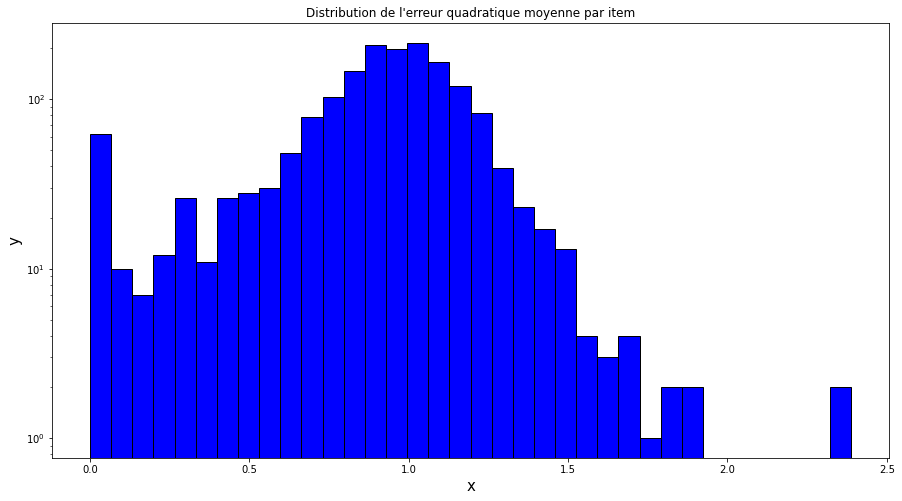

In [121]:
''' Distribution de l'erreur quadratique moyenne '''
plt.figure(figsize=(15,8))
plt.hist(RMSE, color = 'blue', edgecolor = 'black', bins = int(180/5), log=True)
# Add labels
plt.title('Distribution de l\'erreur quadratique moyenne par item')
plt.xlabel('x',fontsize=15)
plt.ylabel('y',fontsize=15)

## Question 3

## Question 4 

## Question 5 